In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Metric
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch

import numpy as np
import pandas as pd

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr

from tqdm import tqdm
import optuna

from catboost import MultiTargetCustomMetric
from catboost import CatBoostClassifier, Pool

from xgboost import XGBClassifier


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import logging

logger = logger = logging.getLogger(__name__)
logging.basicConfig(filename='main.log', level=logging.INFO)

# ЗАГРУЗКА ДАННЫХ

In [4]:
path_1 = 'data/250218.csv'
path_2 = 'data/250219.csv'

data_1 = pd.read_csv(path_1, delimiter=';')
data_2 = pd.read_csv(path_2, delimiter=';')

# data_1 = data_1[data_1['Timestamp'] != 'Timestamp']

In [5]:
print('data_1 stops:', len(data_1[data_1['Timestamp'] == 'Timestamp']))
print('data_2 stops:', len(data_2[data_2['Timestamp'] == 'Timestamp']))

data_1 stops: 16
data_2 stops: 13


In [6]:
described_data_1 = data_1.describe().loc['unique'] - 1
data_1_one_unique = described_data_1[described_data_1 == 1]

In [7]:
described_data_2 = data_2.describe().loc['unique'] - 1
data_2_one_unique = described_data_2[described_data_2 == 1]

In [8]:
data_1_one_unique.to_frame().T

,Current failure,Failure code block,Block connection # 7,Block connection # 8,Block connection # 9,Block connection # 10,Block connection # 11,Block connection # 12,Block connection # 13,Block connection # 14,...,SO Angle 7 1,SO Angle 7 2,SO Angle 7 3,SO Angle 8 1,SO Angle 8 2,SO Angle 8 3,Work time CPU,Automatic flag,Automatic regime,Automatic step
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [9]:
data_2_one_unique.index

Index(['Current failure', 'Failure code block', 'Block connection # 7',
       'Block connection # 8', 'Block connection # 9', 'Block connection # 10',
       'Block connection # 11', 'Block connection # 12',
       'Block connection # 13', 'Block connection # 14',
       'Block connection # 15', 'PDU Joy3', 'PDU Joy3 buttons',
       'HV Motor t*C state', 'HV Motor t*C', 'HV Motor state',
       'DVS Engine t*C state', 'DVS Engine t*C', 'DVS Fuel', 'DVS RPM',
       'DVS Engine state', 'DVS Oil pressure', 'HIDR Oil level', 'HIDR RD2',
       'HIDR RD3', 'HIDR RD4', 'HIDR RD5', 'HIDR RD6', 'HIDR RD7', 'HIDR RD8',
       'HIDR RD9', 'HIDR RD10', 'HIDR RD11', 'HIDR RD12', 'HIDR RD13',
       'HIDR RD14', 'HIDR RD15', 'HIDR RD16', 'Electric Ucpu', 'SO Angle 5 1',
       'SO Angle 5 2', 'SO Angle 5 3', 'SO Angle 6 1', 'SO Angle 6 2',
       'SO Angle 6 3', 'SO Angle 7 1', 'SO Angle 7 2', 'SO Angle 7 3',
       'SO Angle 8 1', 'SO Angle 8 2', 'SO Angle 8 3', 'Work time CPU',
       'Automat

In [10]:
def plot_time_periods(df: pd.DataFrame, time_col: str, target_col: str, plots_per_row=2):
    break_points = [0] + df[df[time_col] == 'Timestamp'].index.to_list()
    
    segments = []
    for idx in range(len(break_points) - 1):
        segment = df[break_points[idx] + 1:break_points[idx + 1]]
        segments.append(segment)

    n_segments = len(segments)
    n_rows = (n_segments + plots_per_row - 1) // plots_per_row
    fig_width = 10 * plots_per_row
    fig_height = 3 * n_rows
    fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(fig_width, fig_height))
    axes = axes.flatten()

    
    for i, (segment, ax) in enumerate(zip(segments, axes), 1):
        segment['is_nonzero'] = segment[target_col] != '0' * 16
        segment['is_nonzero'] = segment['is_nonzero'].astype(int)

        ax.step(segment[time_col].index.to_list(), segment['is_nonzero'], where='post', color='blue')
        ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
        
        ax.set_title(f'Период {i}')
        ax.set_xlabel('Время (idx)')
        ax.set_ylabel('0/1')
        ax.set_ylim(-0.1, 1.1)
        ax.set_yticks([0, 1])
        ax.grid(True, linestyle=':')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

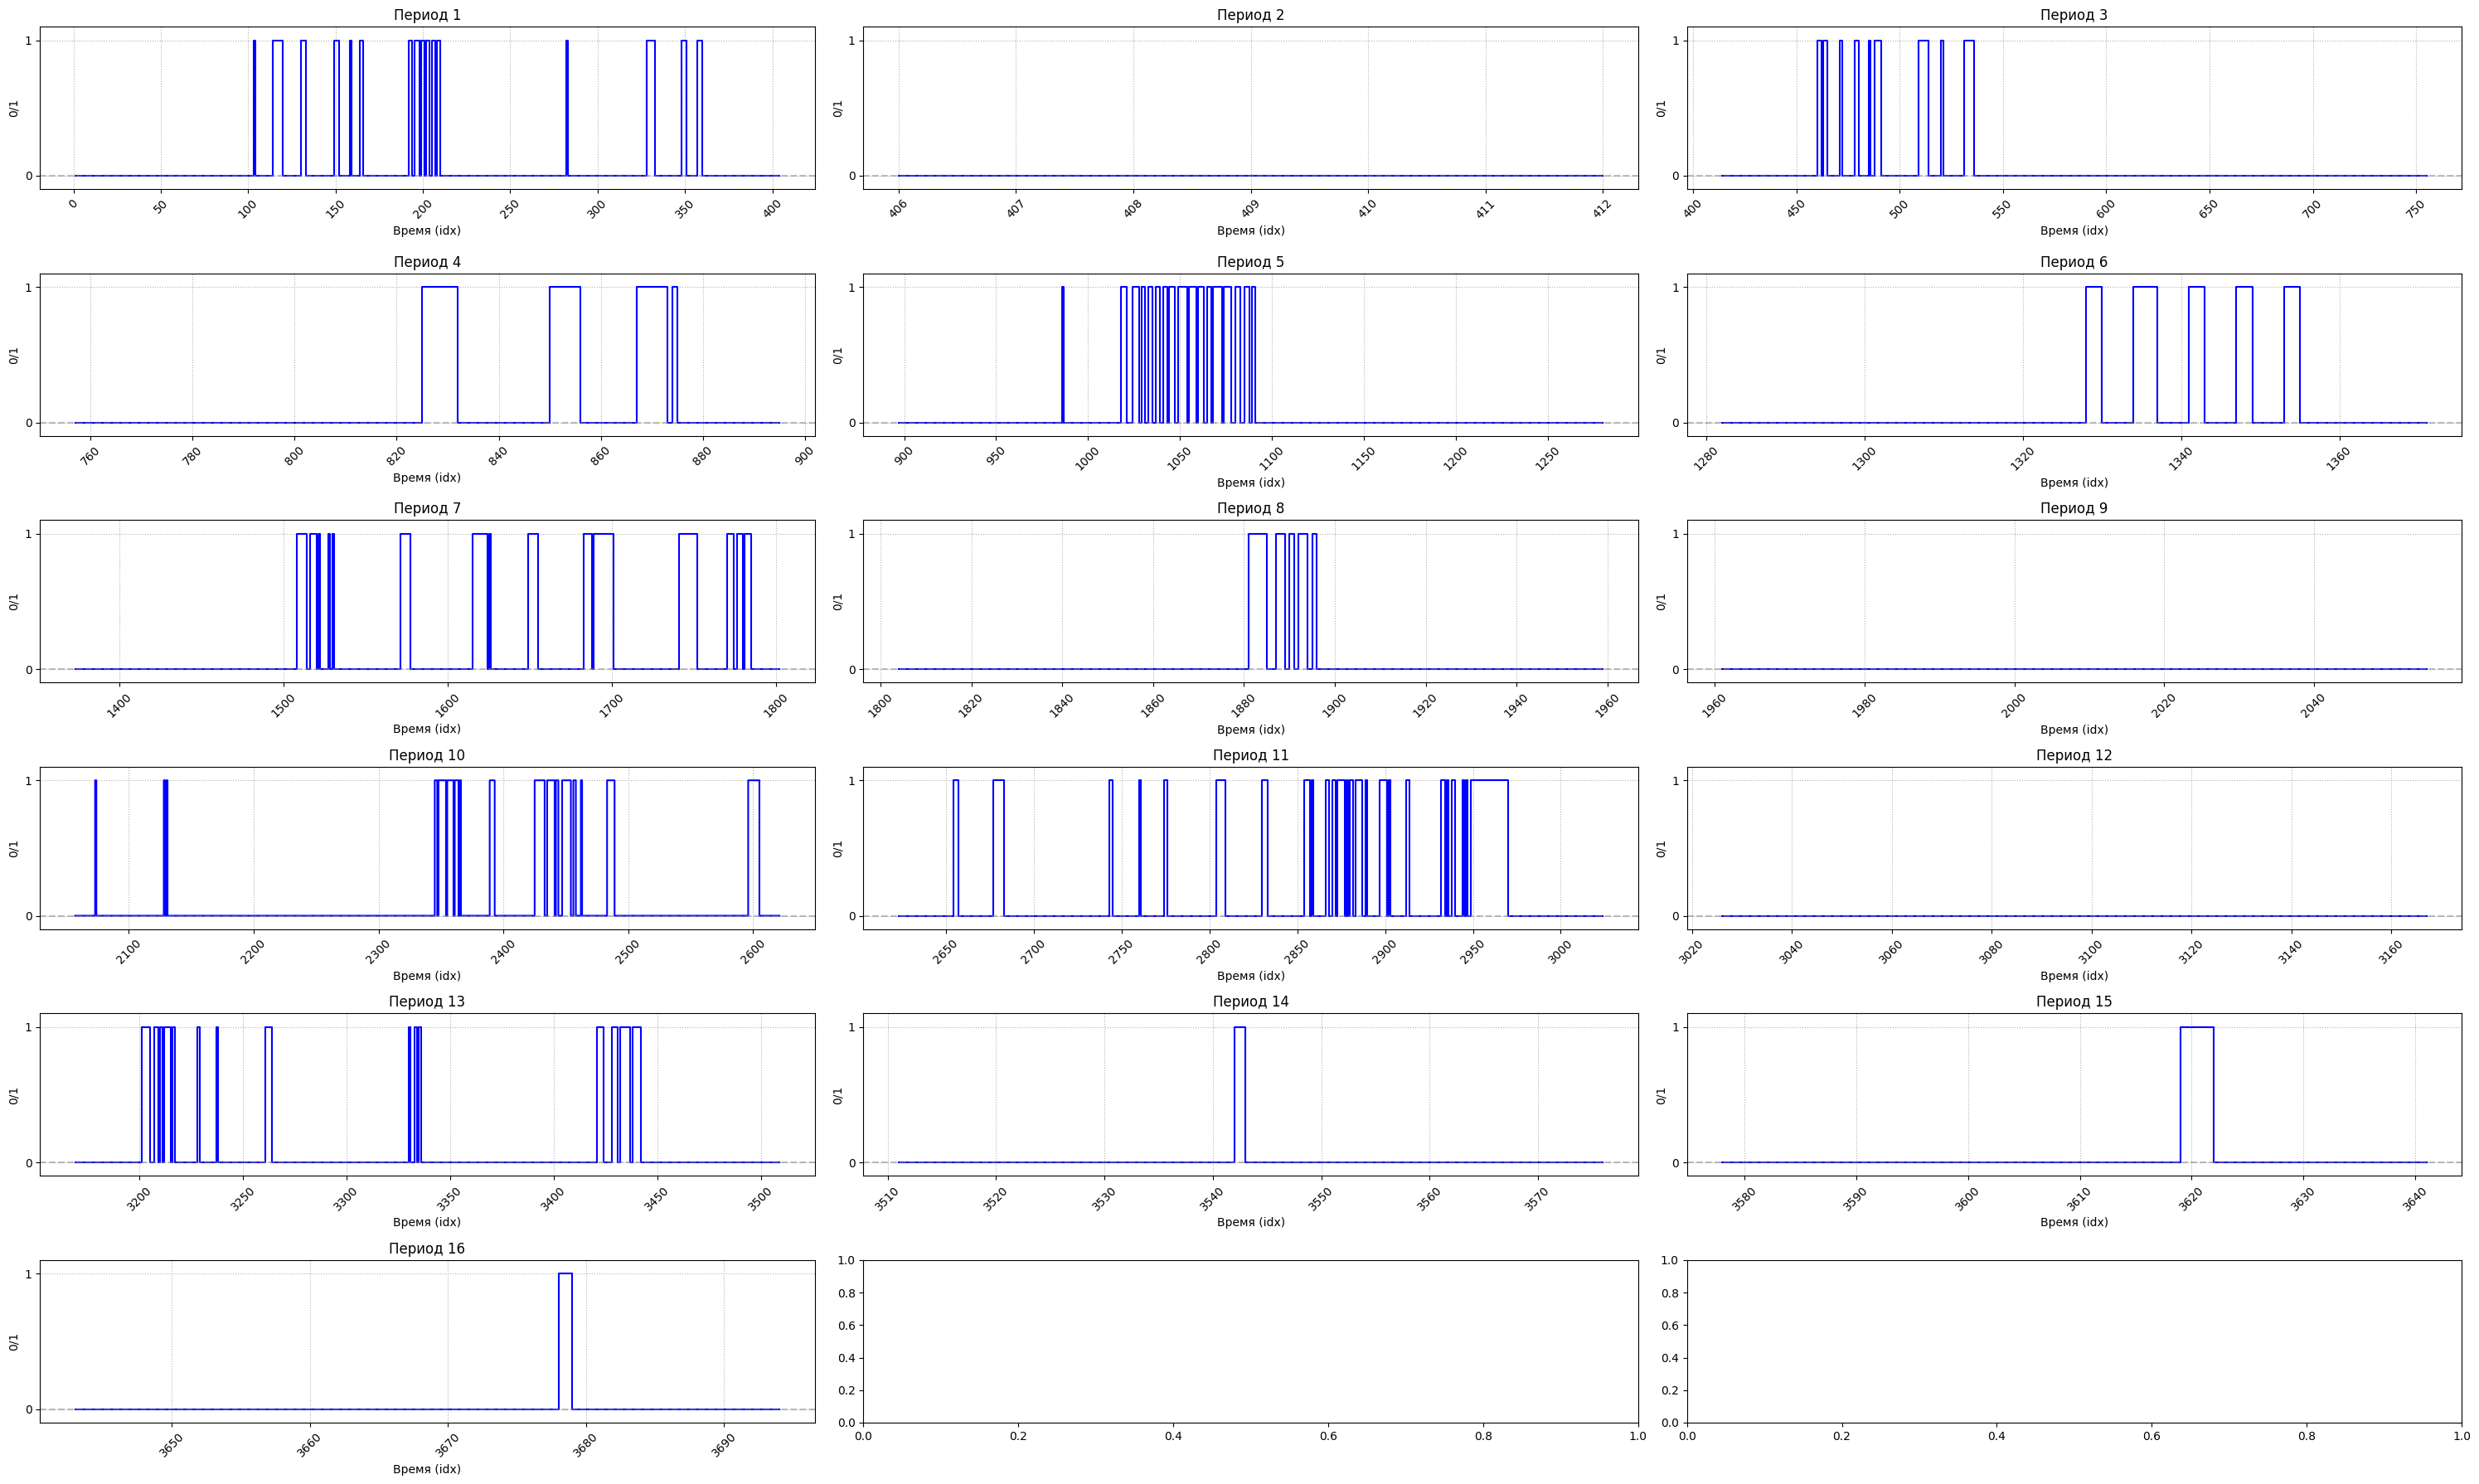

In [11]:
plot_time_periods(data_1, 'Timestamp', 'Comand_vector #0', plots_per_row=3)

In [12]:
def delete_zero_segments(data):
    stops_idx = data[data['Timestamp'] == 'Timestamp'].index.to_list()
    non_zero_dfs = []

    for idx in range(len(stops_idx) - 1):
        segment = data[stops_idx[idx] + 1:stops_idx[idx + 1]]
        if len(segment['Comand_vector #0'].unique()) > 1:
            non_zero_dfs.append(segment)

    new_data = non_zero_dfs[0]
    for i in range(1, len(non_zero_dfs)):
        new_data = pd.concat([new_data, non_zero_dfs[i]], ignore_index=True)
    return new_data

In [13]:
data_1 = delete_zero_segments(data_1)
data_2 = delete_zero_segments(data_2)

In [14]:
command_vector_0_masks = {
    "R1_1": 0x1,
    "R1_2": 0x2,
    "R2_1": 0x4,
    "R2_2": 0x8,
    "R3_1": 0x10,
    "R3_2": 0x20,
    "R4_1": 0x40,
    "R4_2": 0x80,
    "R5_1": 0x100,
    "R5_2": 0x200,
    "R6_1": 0x400,
    "R6_2": 0x800,
    "R7_1": 0x1000,
    "R7_2": 0x2000,
    "R8_1": 0x4000,
    "R8_2": 0x8000,
    "R9_1": 0x10000,
    "R9_2": 0x20000,
    "R10_1": 0x40000,
    "R10_2": 0x80000,
    "R11_1": 0x100000,
    "R11_2": 0x200000,
    "R12_1": 0x400000,
    "R12_2": 0x800000,
    "R13_1": 0x1000000,
    "R13_2": 0x2000000,
    "R14_1": 0x4000000,
    "R14_2": 0x8000000,
    "R15_1": 0x10000000,
    "R15_2": 0x20000000,
    "R16_1": 0x40000000,
    "R16_2": 0x80000000,
    "R17_1": 0x100000000,
    "R17_2": 0x200000000,
    "R18_1": 0x400000000,
    "R18_2": 0x800000000,
    "R19_1": 0x1000000000,
    "R19_2": 0x2000000000,
    "R20_1": 0x4000000000,
    "R20_2": 0x8000000000,
    "R21_1": 0x10000000000,
    "R21_2": 0x20000000000,
    "R22_1": 0x40000000000,
    "R22_2": 0x80000000000,
    "R23_1": 0x100000000000,
    "R23_2": 0x200000000000,
    "R24_1": 0x400000000000,
    "R24_2": 0x800000000000,
    "R25_1": 0x1000000000000,
    "R25_2": 0x2000000000000,
    "R26_1": 0x4000000000000,
    "R26_2": 0x8000000000000,
    "R27_1": 0x10000000000000,
    "R27_2": 0x20000000000000,
    "R28_1": 0x40000000000000,
    "R28_2": 0x80000000000000,
    "R29_1": 0x100000000000000,
    "R29_2": 0x200000000000000,
    "R30_1": 0x400000000000000,
    "R30_2": 0x800000000000000,
    "R31_1": 0x1000000000000000,
    "R31_2": 0x2000000000000000,
    "R32_1": 0x4000000000000000,
    "R32_2": 0x8000000000000000
}
len(command_vector_0_masks)

64

In [15]:
def decode_command_vector(hex_str):
    value = int(hex_str, 16)
    active_commands = []
    for name, mask in command_vector_0_masks.items():
        if value & mask:
            active_commands.append(name)
    return active_commands, [hex(command_vector_0_masks[i]) for i in active_commands]

In [16]:
unique_comand2 = data_2[data_2['Comand_vector #0'] != 'Comand_vector #0']['Comand_vector #0'].unique()

comands2 = []
for i in unique_comand2:
    decoded = decode_command_vector(i)
    # print(f'{i}\n{decoded}\n')
    comands2.extend(decoded[0])

print(sorted(list(set(comands2))))

['R11_1', 'R11_2', 'R12_1', 'R12_2', 'R13_1', 'R13_2', 'R15_1', 'R15_2', 'R3_1', 'R4_1', 'R5_1', 'R6_1', 'R6_2', 'R7_1', 'R7_2', 'R8_1', 'R8_2']


In [17]:
f = lambda hex_str: tuple(decode_command_vector(hex_str)[0])

data_1['decoded_comand #0'] = data_1[data_1['Comand_vector #0'] != 'Comand_vector #0']['Comand_vector #0'].apply(f)
data_2['decoded_comand #0'] = data_2[data_2['Comand_vector #0'] != 'Comand_vector #0']['Comand_vector #0'].apply(f)

In [18]:
pdu_joy_masks = {
    "FORWARD": 0x1000,
    "BACK": 0x2000,
    "LEFT": 0x4000,
    "RIGHT": 0x8000,
    "BTN_LEFT": 0x0100,
    "BTN_RIGHT": 0x0200,
    "L_AFTER_DEV": 0x0400,
    "R_AFRER_DEV": 0x0800,
}

In [19]:
def decode_pdu_joy(hex_str):
    value = int(hex_str, 16)
    data = []
    for name, mask in pdu_joy_masks.items():
        if value & mask:
            data.append(name)
    data.append(value & 0xFF)
    return tuple(data)

In [20]:
btns = lambda hex_str: decode_pdu_joy(hex_str)[:-1] if 'PDU Joy' not in hex_str else ()
dev = lambda hex_str: (decode_pdu_joy(hex_str)[-1]) / 100 if 'PDU Joy' not in hex_str else 0
for i in range(1, 4):
    data_1[f'decoded_joy{i}_btns'] = data_1[f'PDU Joy{i}'].apply(btns)
    data_1[f'deviation_joy{i}'] = data_1[f'PDU Joy{i}'].apply(dev)

    data_2[f'decoded_joy{i}_btns'] = data_2[f'PDU Joy{i}'].apply(btns)
    data_2[f'deviation_joy{i}'] = data_2[f'PDU Joy{i}'].apply(dev)

In [21]:
print(data_1['decoded_joy1_btns'].unique())
print(data_1['decoded_joy2_btns'].unique())
print(data_1['decoded_joy3_btns'].unique())

[() ('LEFT',) ('RIGHT',) ('FORWARD',) ('BACK',)]
[() ('FORWARD',) ('RIGHT',) ('BACK',) ('RIGHT', 'BTN_LEFT')
 ('LEFT', 'BTN_LEFT') ('FORWARD', 'BTN_LEFT') ('BACK', 'BTN_LEFT')]
[()]


In [22]:
print(data_2['decoded_joy1_btns'].unique())
print(data_2['decoded_joy2_btns'].unique())
print(data_2['decoded_joy3_btns'].unique())

[() ('FORWARD',) ('BACK',) ('FORWARD', 'BTN_RIGHT') ('BACK', 'BTN_RIGHT')
 ('BACK', 'BTN_LEFT') ('LEFT',) ('RIGHT',)]
[() ('RIGHT', 'BTN_LEFT') ('FORWARD',) ('LEFT', 'BTN_LEFT') ('BACK',)
 ('FORWARD', 'BTN_RIGHT') ('BACK', 'BTN_RIGHT')]
[()]


one-hot encoding

In [23]:
data_1.at[405, 'decoded_comand #0'] = tuple(command_vector_0_masks.keys())[:30]
data_1.at[405, 'decoded_joy1_btns'] = tuple(pdu_joy_masks.keys())
data_1.at[405, 'decoded_joy2_btns'] = tuple(pdu_joy_masks.keys())
data_1.at[405, 'decoded_joy3_btns'] = tuple(pdu_joy_masks.keys())
# data_1['decoded_comand #0'].unique()

data_2.at[734, 'decoded_comand #0'] = tuple(command_vector_0_masks.keys())[:30]
data_2.at[405, 'decoded_joy1_btns'] = tuple(pdu_joy_masks.keys())
data_2.at[405, 'decoded_joy2_btns'] = tuple(pdu_joy_masks.keys())
data_2.at[405, 'decoded_joy3_btns'] = tuple(pdu_joy_masks.keys())
# data_2['decoded_comand #0'].unique()

In [24]:
mlb1 = MultiLabelBinarizer()
mlb_joy1 = MultiLabelBinarizer()
mlb_joy2 = MultiLabelBinarizer()
mlb_joy3 = MultiLabelBinarizer()


ohe_data_1 = mlb1.fit_transform(data_1['decoded_comand #0'].apply(lambda x: x if isinstance(x, tuple) else ()))
ohe_data_2 = mlb1.fit_transform(data_2['decoded_comand #0'].apply(lambda x: x if isinstance(x, tuple) else ()))

ohe_data_1_joy1 = mlb_joy1.fit_transform(data_1['decoded_joy1_btns'].apply(lambda x: x if isinstance(x, tuple) else ()))
ohe_data_1_joy2 = mlb_joy2.fit_transform(data_1['decoded_joy2_btns'].apply(lambda x: x if isinstance(x, tuple) else ()))
ohe_data_1_joy3 = mlb_joy3.fit_transform(data_1['decoded_joy3_btns'].apply(lambda x: x if isinstance(x, tuple) else ()))

ohe_data_2_joy1 = mlb_joy1.fit_transform(data_2['decoded_joy1_btns'].apply(lambda x: x if isinstance(x, tuple) else ()))
ohe_data_2_joy2 = mlb_joy2.fit_transform(data_2['decoded_joy2_btns'].apply(lambda x: x if isinstance(x, tuple) else ()))
ohe_data_2_joy3 = mlb_joy3.fit_transform(data_2['decoded_joy3_btns'].apply(lambda x: x if isinstance(x, tuple) else ()))

ohe_df1 = pd.DataFrame(ohe_data_1, columns=mlb1.classes_)
ohe_df2 = pd.DataFrame(ohe_data_2, columns=mlb1.classes_)

ohe_df1_joy1 = pd.DataFrame(ohe_data_1_joy1, columns=[f'{col}_Joy1' for col in mlb_joy1.classes_])
ohe_df1_joy2 = pd.DataFrame(ohe_data_1_joy2, columns=[f'{col}_Joy2' for col in mlb_joy2.classes_])
ohe_df1_joy3 = pd.DataFrame(ohe_data_1_joy3, columns=[f'{col}_Joy3' for col in mlb_joy3.classes_])

ohe_df2_joy1 = pd.DataFrame(ohe_data_2_joy1, columns=[f'{col}_Joy1' for col in mlb_joy1.classes_])
ohe_df2_joy2 = pd.DataFrame(ohe_data_2_joy2, columns=[f'{col}_Joy2' for col in mlb_joy2.classes_])
ohe_df2_joy3 = pd.DataFrame(ohe_data_2_joy3, columns=[f'{col}_Joy3' for col in mlb_joy3.classes_])

data_1 = pd.concat([data_1, ohe_df1, ohe_df1_joy1, ohe_df1_joy2, ohe_df1_joy3], axis=1)
data_2 = pd.concat([data_2, ohe_df2, ohe_df2_joy1, ohe_df2_joy2, ohe_df2_joy3], axis=1)

In [25]:
list(data_1.columns)

['Timestamp',
 'Cpu regime',
 'Current failure',
 'Failure code block',
 'Comand_vector #0',
 'Comand_vector #1',
 'Block connection # 0',
 'Block connection # 1',
 'Block connection # 2',
 'Block connection # 3',
 'Block connection # 4',
 'Block connection # 5',
 'Block connection # 6',
 'Block connection # 7',
 'Block connection # 8',
 'Block connection # 9',
 'Block connection # 10',
 'Block connection # 11',
 'Block connection # 12',
 'Block connection # 13',
 'Block connection # 14',
 'Block connection # 15',
 'PDU di buttons',
 'PDU Control',
 'PDU Joy1',
 'PDU Joy2',
 'PDU Joy3',
 'PDU Joy1 buttons',
 'PDU Joy2 buttons',
 'PDU Joy3 buttons',
 'PDU Buttons matrix',
 'HV Motor t*C state',
 'HV Motor t*C',
 'HV Motor state',
 'HV Motor work',
 'HV Riz',
 'HV Uphase',
 'HV Uphase.1',
 'HV Uphase.2',
 'HV Iphase',
 'HV Iphase.1',
 'HV Iphase.2',
 'HV Phasing',
 'HV Phasing.1',
 'HV Phasing.2',
 'DVS Engine t*C state',
 'DVS Engine t*C',
 'DVS Fuel',
 'DVS RPM',
 'DVS Engine state',
 

УДАЛЕНИЕ НЕНУЖНЫХ ФИЧ

In [26]:
columns_to_drop = ['Current failure', 'Failure code block',
                   'HV Motor t*C state',
                   'HV Motor t*C',
                   'HV Motor state',
                   'DVS Engine t*C state',
                   'DVS Engine t*C',
                   'DVS Fuel',
                   'DVS RPM',
                   'DVS Engine state',
                   'DVS Oil pressure',
                   'HIDR Oil level',
                   'Work time PUD',
                   'Work time CPU',
                   'Automatic flag',
                   'Automatic regime',
                   'Automatic step',
                   'Timestamp',
                   'Comand_vector #0',
                   'Comand_vector #1',
                   'PDU Joy1',
                   'PDU Joy2',
                   'PDU Joy3',
                   'decoded_comand #0',
                   'decoded_joy1_btns',
                   'decoded_joy2_btns',
                   'decoded_joy3_btns',                   
]
for i in range(7, 16):
    columns_to_drop.append(f'Block connection # {i}')

for i in range(2, 17):
    columns_to_drop.append(f'HIDR RD{i}')

for i in range(5, 9):
    for j in range(1, 4):
        columns_to_drop.append(f'SO Angle {i} {j}')

len(columns_to_drop)

63

In [27]:
data_1 = data_1.drop(columns=columns_to_drop)
data_2 = data_2.drop(columns=columns_to_drop)

In [28]:
len(list(data_1.columns))

100

In [29]:
def convert_fun(x):
    try:
        return float(x.replace(',', '.'))
    except Exception:
        return x

def convert_col(col_name):
    data_1[col_name] = data_1[col_name].apply(convert_fun)
    data_2[col_name] = data_2[col_name].apply(convert_fun)


to_float_cols = [
    'HV Iphase',
    'HV Iphase.1',
    'HV Iphase.2',
    'HV Uphase',
    'HV Uphase.1',
    'HV Uphase.2',
    'HV Phasing',
    'HV Phasing.1',
    'HV Phasing.2',
    'HIDR t*C',
    'Electric Upow',
    'Electric Ucpu',
    'Electric Ifull',
]

for i in range(1, 5):
    for j in range(1, 4):
        to_float_cols.append(f'SO Angle {i} {j}')

for col in to_float_cols:
    convert_col(col)

for i in range(7):
    data_1[f'Block connection # {i}'] = data_1[f'Block connection # {i}'].apply(lambda x: float(x[:-2].replace(',', '.')) / 100 if 'Block' not in x else x)
    data_2[f'Block connection # {i}'] = data_2[f'Block connection # {i}'].apply(lambda x: float(x[:-2].replace(',', '.')) / 100 if 'Block' not in x else x)

data_1['PDU Buttons matrix'] = data_1['PDU Buttons matrix'].apply(lambda x: int(x, 16) if 'PDU' not in x else x)
data_2['PDU Buttons matrix'] = data_2['PDU Buttons matrix'].apply(lambda x: int(x, 16) if 'PDU' not in x else x)

In [30]:
def transform_categorical(col_name):
    unique_1 = [i for i in data_1[col_name].unique() if i != col_name]
    unique_2 = [i for i in data_2[col_name].unique() if i != col_name]

    sl1 = {i: j for i, j in zip(sorted(unique_1), range(len(unique_1)))}
    sl2 = {i: j for i, j in zip(sorted(unique_2), range(len(unique_2)))}

    data_1[col_name] = data_1[col_name].apply(lambda x: sl1[x] if x in sl1 else x)
    data_2[col_name] = data_2[col_name].apply(lambda x: sl2[x] if x in sl2 else x)


categorical_cols = [
    'Cpu regime',
    'PDU di buttons',
    'PDU Control',
    'PDU Joy1 buttons',
    'PDU Joy2 buttons',
    'PDU Joy3 buttons',
    'HV Motor work',
    'HV Riz',
    'HIDR t*C state',
    'HIDR RD1',    
]

for col in categorical_cols:
    transform_categorical(col)

In [31]:
for i in range(1, 5):
    for j in range(1, 4):
        data_1['is_section'] = data_1[f'SO Angle {i} {j}'].apply(lambda x: isinstance(x, str))
        data_2['is_section'] = data_2[f'SO Angle {i} {j}'].apply(lambda x: isinstance(x, str))

        data_1['group'] = data_1['is_section'].cumsum()
        data_2['group'] = data_2['is_section'].cumsum()

        data_1['numeric_values'] = pd.to_numeric(data_1[f'SO Angle {i} {j}'], errors='coerce')
        data_2['numeric_values'] = pd.to_numeric(data_2[f'SO Angle {i} {j}'], errors='coerce')

        data_1[f'Delta_angle_{i} {j}'] = data_1.groupby('group')['numeric_values'].transform(
            lambda x: x.diff() if x.notna().any() else np.nan
        )
        data_2[f'Delta_angle_{i} {j}'] = data_2.groupby('group')['numeric_values'].transform(
            lambda x: x.diff() if x.notna().any() else np.nan
        )

        data_1.loc[data_1['is_section'], f'Delta_angle_{i} {j}'] = np.nan
        data_2.loc[data_2['is_section'], f'Delta_angle_{i} {j}'] = np.nan

        data_1 = data_1.drop(columns=[f'SO Angle {i} {j}', 'is_section', 'group', 'numeric_values'])
        data_2 = data_2.drop(columns=[f'SO Angle {i} {j}', 'is_section', 'group', 'numeric_values'])

In [32]:
for i in range(1, 5):
    for j in range(1, 4):
        col_name = f'Delta_angle_{i} {j}'

        data_1 = data_1[abs(data_1[col_name]) < 30]
        data_2 = data_2[abs(data_2[col_name]) < 30]

In [33]:
data_1

,Cpu regime,Block connection # 0,Block connection # 1,Block connection # 2,Block connection # 3,Block connection # 4,Block connection # 5,Block connection # 6,PDU di buttons,PDU Control,...,Delta_angle_1 3,Delta_angle_2 1,Delta_angle_2 2,Delta_angle_2 3,Delta_angle_3 1,Delta_angle_3 2,Delta_angle_3 3,Delta_angle_4 1,Delta_angle_4 2,Delta_angle_4 3
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0.97,0.95,0.99,0.97,0.99,0.99,0.97,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.97,0.95,0.99,0.97,0.99,0.99,0.97,0,0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3026,1,0.97,1.0,0.99,0.98,0.98,0.98,0.99,1,0,...,0.0,4.0,-15.0,0.0,8.0,6.0,0.0,11.0,-2.0,0.0
3027,1,0.97,1.0,0.99,0.98,0.98,0.98,0.99,1,0,...,0.0,-3.0,0.0,0.0,12.0,5.0,0.0,-10.0,6.0,0.0
3028,1,0.97,1.0,0.99,0.98,0.98,0.98,0.99,1,0,...,0.0,-7.0,14.0,0.0,2.0,-1.0,0.0,-2.0,-3.0,0.0
3029,1,0.97,1.0,0.99,0.98,0.98,0.98,0.99,1,0,...,0.0,1.0,8.0,0.0,-9.0,-5.0,0.0,12.0,-3.0,0.0


In [34]:
data_2

,Cpu regime,Block connection # 0,Block connection # 1,Block connection # 2,Block connection # 3,Block connection # 4,Block connection # 5,Block connection # 6,PDU di buttons,PDU Control,...,Delta_angle_1 3,Delta_angle_2 1,Delta_angle_2 2,Delta_angle_2 3,Delta_angle_3 1,Delta_angle_3 2,Delta_angle_3 3,Delta_angle_4 1,Delta_angle_4 2,Delta_angle_4 3
1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.97,0.98,1.00,1.00,0.00,0.99,0.98,0,0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
5,0,0.97,0.98,1.00,1.00,0.94,0.99,0.98,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871,2,1.00,0.98,1.00,1.00,0.99,1.00,0.99,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4872,2,1.00,0.98,1.00,1.00,0.99,1.00,0.99,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
4873,2,1.00,0.98,1.00,0.99,0.99,1.00,0.99,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4874,2,1.00,0.98,1.00,0.99,0.99,1.00,0.99,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# ВИЗУАЛИЗАЦИЯ

In [35]:
target_columns = [col for col in data_1.columns if col[0] == 'R' and 'Joy' not in col]

feature_columns = [col for col in  data_1.columns if col not in target_columns]

correlations = data_1[feature_columns].corrwith(data_1[target_columns[0]])
for target in target_columns[1:]:
    correlations = pd.concat([correlations, data_1[feature_columns].corrwith(data_1[target])], axis=1)

correlations.columns = target_columns

In [36]:
for target in target_columns:
    data_1[target] = pd.to_numeric(data_1[target], errors='coerce').fillna(0).astype(int)

for feature in feature_columns:
    if not np.issubdtype(data_1[feature].dtype, np.number):
        try:
            data_1[feature] = pd.to_numeric(data_1[feature], errors='coerce')
        except:
            continue
        
data_1 = data_1.fillna(0)

In [37]:
for target in target_columns:
    data_2[target] = pd.to_numeric(data_2[target], errors='coerce').fillna(0).astype(int)

for feature in feature_columns:
    if not np.issubdtype(data_2[feature].dtype, np.number):
        try:
            data_2[feature] = pd.to_numeric(data_2[feature], errors='coerce')
        except:
            continue
        
data_2 = data_2.fillna(0)

Point biserial

In [38]:
data = pd.concat([data_1, data_2])

In [39]:
pbs_corrs = pd.DataFrame(index=feature_columns, columns=target_columns)

for target in target_columns:
    for feature in feature_columns:
        if np.issubdtype(data[feature].dtype, np.number) and np.issubdtype(data[target].dtype, np.number):
            try:
                corr, _ = pointbiserialr(data[feature], data[target])
                pbs_corrs.loc[feature, target] = corr
            except:
                pbs_corrs.loc[feature, target] = np.nan
        else:
            pbs_corrs.loc[feature, target] = np.nan

pbs_corrs = pbs_corrs.dropna(how='all', axis=0).dropna(how='all', axis=1)

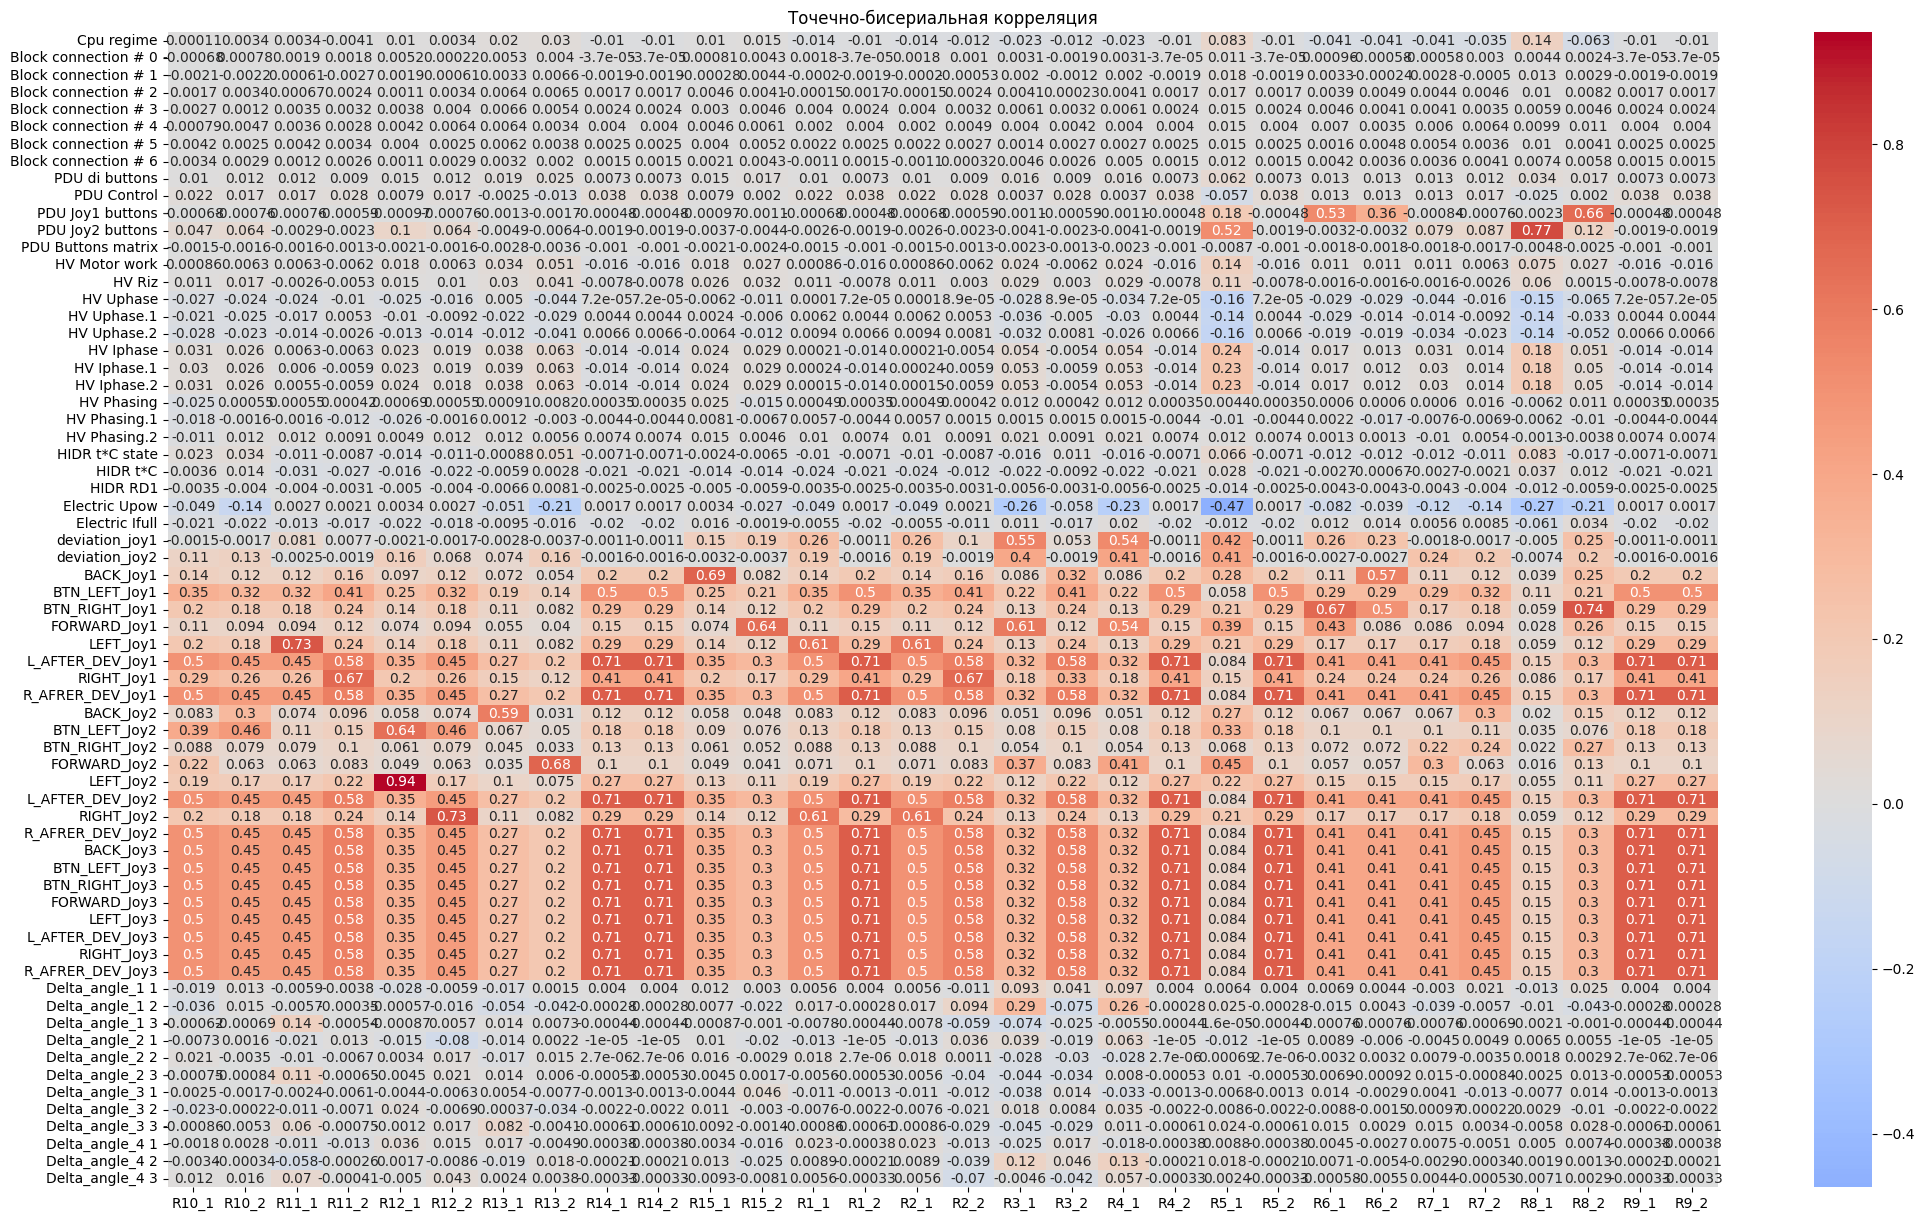

In [40]:
plt.figure(figsize=(25, 15))
sns.heatmap(pbs_corrs.astype(float), annot=True, cmap='coolwarm', center=0)
plt.title("Точечно-бисериальная корреляция")
plt.show()

In [41]:
selected_features_corr = []

for i in range(len(pbs_corrs)):
    if any([abs(corr) >= 0.58 for corr in pbs_corrs.iloc[i]]):
        selected_features_corr.append(i)

In [42]:
selected_features_corr = list(pbs_corrs.iloc[selected_features_corr].index)

In [43]:
len(selected_features_corr)

24

Нормализация

In [44]:
data = pd.concat([data_1, data_2])

In [45]:
scaler = StandardScaler()

data_scaled = scaler.fit_transform(data[feature_columns])
data_scaled

array([[ -1.81477202, -10.22859186, -10.15456687, ...,  -0.02230852,
         -0.01264121,  -0.01982865],
       [ -1.81477202, -10.22859186, -10.15456687, ...,  -0.02230852,
         -0.01264121,  -0.01982865],
       [ -1.81477202, -10.22859186, -10.15456687, ...,  -0.02230852,
         -0.01264121,  -0.01982865],
       ...,
       [  0.61090823,   0.26002086,   0.04385683, ...,  -0.02230852,
         -0.01264121,  -0.01982865],
       [  0.61090823,   0.26002086,   0.04385683, ...,  -0.02230852,
         -0.01264121,  -0.01982865],
       [  0.61090823,   0.05024861,   0.04385683, ...,  -0.02230852,
         -0.01264121,  -0.01982865]])

PCA

In [46]:
pca = PCA()
data_pca = pca.fit_transform(data_scaled)
evr = pca.explained_variance_ratio_
cvr = np.cumsum(evr)
print(evr, cvr)

[2.07482081e-01 1.02306681e-01 8.40176934e-02 4.51219102e-02
 4.21749620e-02 3.68842629e-02 3.30209655e-02 2.85928941e-02
 2.48266354e-02 2.44348651e-02 2.28808302e-02 2.14764692e-02
 2.00159987e-02 1.77795596e-02 1.70448423e-02 1.58761723e-02
 1.57959859e-02 1.56341346e-02 1.44401161e-02 1.39981637e-02
 1.33511756e-02 1.27460383e-02 1.25239693e-02 1.17365323e-02
 1.07955722e-02 9.79680932e-03 9.72976497e-03 9.36025747e-03
 9.19605977e-03 8.97297101e-03 8.66883010e-03 8.65291914e-03
 8.31385436e-03 8.10239445e-03 6.67924625e-03 6.59707036e-03
 6.37443394e-03 5.73821594e-03 5.62995376e-03 4.09338177e-03
 3.09443804e-03 2.66369369e-03 2.52994142e-03 2.39400380e-03
 2.06757156e-03 2.01385598e-03 1.32812499e-03 1.01876751e-03
 7.51896606e-04 4.85583953e-04 3.18296628e-04 2.37017534e-04
 2.22484939e-04 6.02770664e-06 3.62197622e-06 1.11463096e-17
 9.69002500e-18 7.95072859e-18 7.59975743e-18 3.81311365e-18
 2.78741808e-18 2.10210027e-18 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [47]:
n_components = np.argmax(cvr >= 0.95) + 1
n_components

35

In [48]:
pca = PCA(n_components=n_components)
data_reduced = pca.fit_transform(data_scaled)
print(data.shape[1], data_reduced.shape[1])

100 35


In [49]:
pbs_corrs = pd.DataFrame(index=feature_columns, columns=target_columns)

for target in target_columns:
    for i in range(data_reduced.shape[1]):
        if np.issubdtype(data_reduced[:,i].dtype, np.number) and np.issubdtype(data[target].dtype, np.number):
            try:
                corr, _ = pointbiserialr(data_reduced[:,i], data[target])
                pbs_corrs.loc[str(i), target] = corr
            except:
                pbs_corrs.loc[str(i), target] = np.nan
        else:
            pbs_corrs.loc[str(i), target] = np.nan

pbs_corrs = pbs_corrs.dropna(how='all', axis=0).dropna(how='all', axis=1)

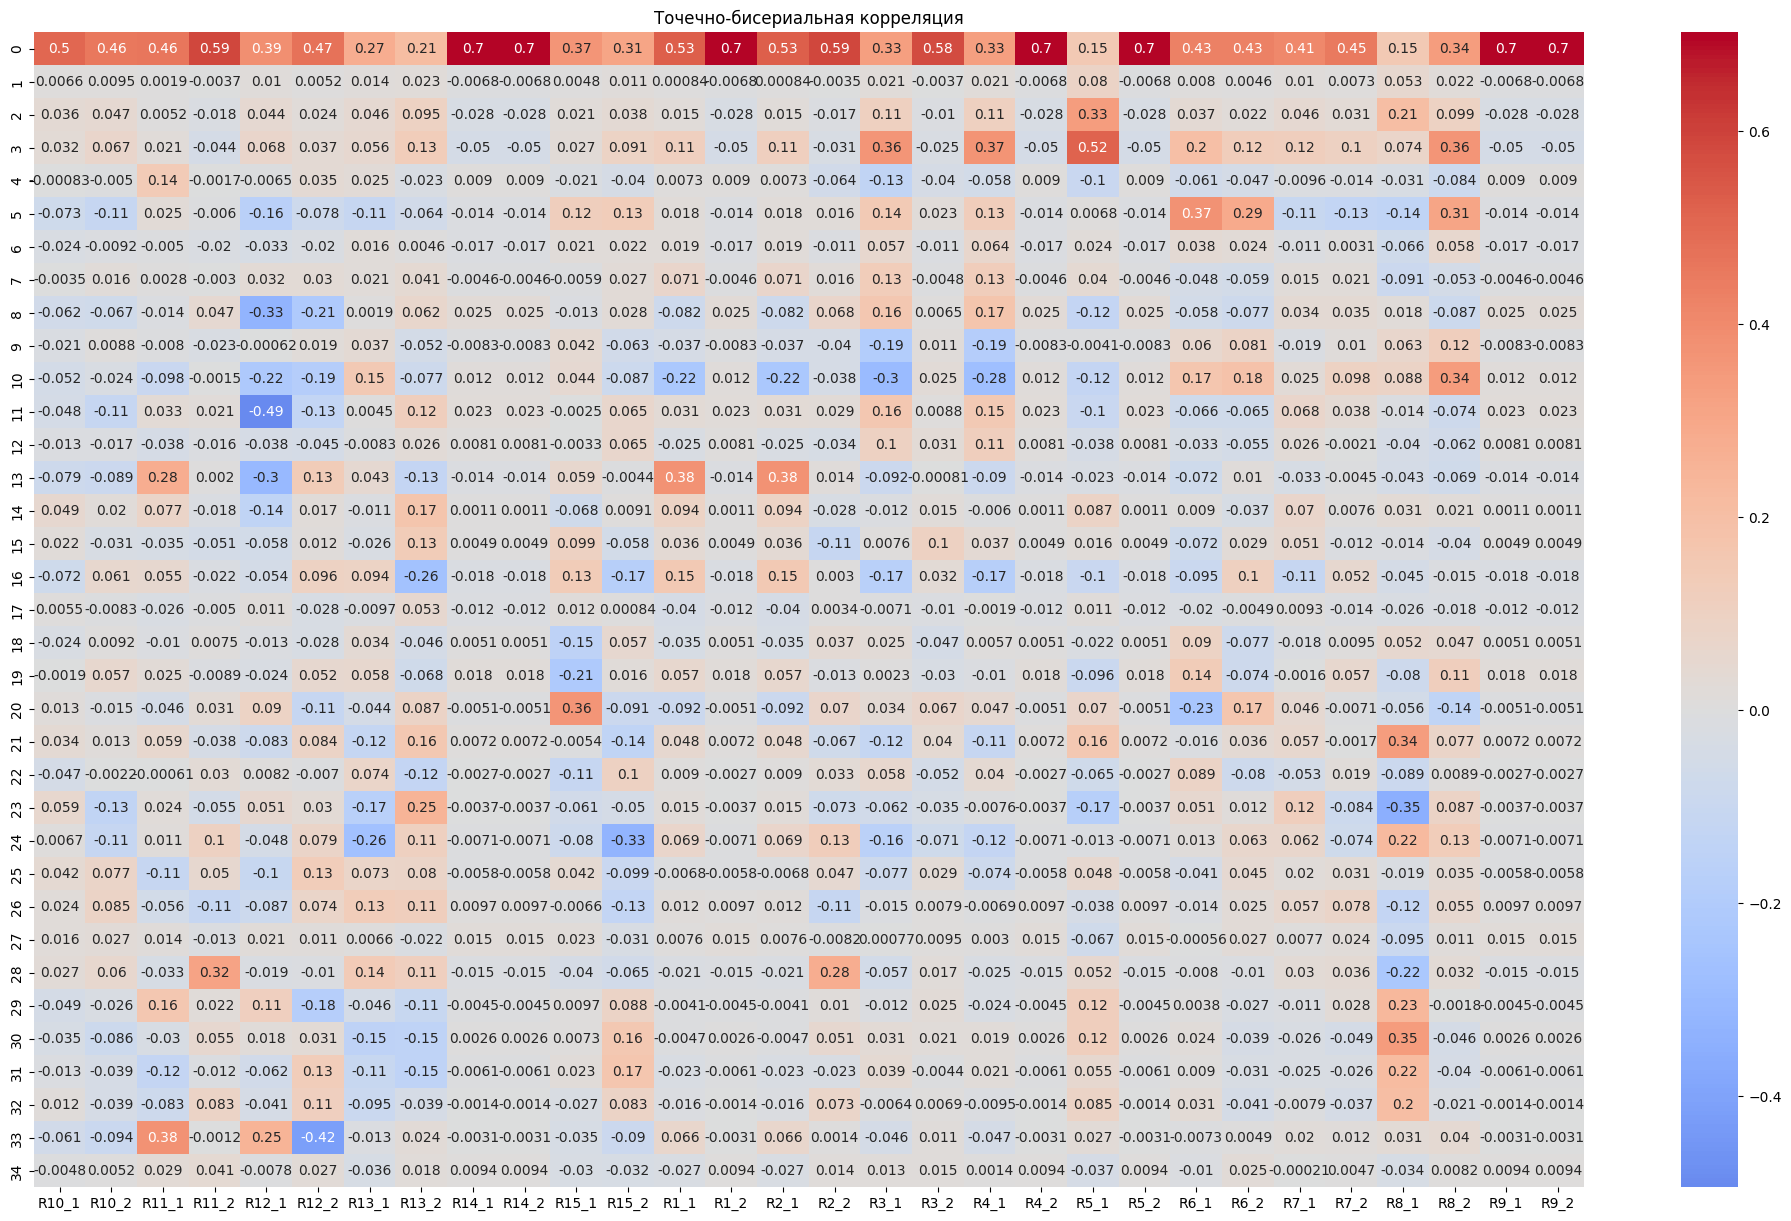

In [50]:
plt.figure(figsize=(25, 15))
sns.heatmap(pbs_corrs.astype(float), annot=True, cmap='coolwarm', center=0)
plt.title("Точечно-бисериальная корреляция")
plt.show()

SPCA

In [51]:
from sklearn.decomposition import SparsePCA

spca = SparsePCA(n_components=29, alpha=0.5, random_state=42)
data_reduced = spca.fit_transform(data_scaled)

# ОТБОР ФИЧ (CATBOOST)

In [52]:
...

Ellipsis

# MODELLING

In [ ]:
def calculate_f1_per_target_lstm(
    y_true, y_pred,
    target_names=None,
    threshold=0.5,
    weighted_by_inverse_frequency=True
):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_binary = (y_pred > threshold).astype(int)

    n_targets = y_true.shape[2]
    
    if target_names is None:
        target_names = [f'R{i}_{j}' for i in range(1, n_targets // 2 + 1) for j in range(1, 3)]
    else:
        assert len(target_names) == n_targets, \
            f"Target names assert error target_names: {len(target_names)} != y_shape: {n_targets}"

    results = {}
    f1_values = []
    label_frequencies = []

    for i, name in enumerate(target_names):
        true_single = y_true[:, :, i].reshape(-1)
        pred_single = y_pred_binary[:, :, i].reshape(-1)

        try:
            f1 = f1_score(true_single, pred_single, average='binary', zero_division=0)
            freq = np.mean(true_single)
            f1_values.append(f1)
            label_frequencies.append(freq)
            results[name] = f1
        except ValueError as e:
            print(f"Ошибка для {name}: {str(e)}")
            results[name] = np.nan
            f1_values.append(np.nan)
            label_frequencies.append(0)

    f1_values = np.array(f1_values)
    label_frequencies = np.array(label_frequencies)

    if weighted_by_inverse_frequency:
        weights = 1.0 / (label_frequencies + 1e-6)
        weights = weights / weights.sum()
        weighted_f1 = np.nansum(f1_values * weights)
    else:
        weighted_f1 = np.nanmean(f1_values)

    return results, weighted_f1

In [54]:
def calculate_f1_per_target_catboost(y_true, y_pred, target_names=None, average='weighted', threshold=0.5):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_pred_binary = (y_pred > threshold).astype(int)
    
    if target_names is None:
        target_names = [f'R{i}_{j}' for i in range(1, y_true.shape[1] // 2 + 1) for j in range(1, 3)]
    
    results = {}
    for i, name in enumerate(target_names):
        true_single = y_true[:, i].reshape(-1)
        pred_single = y_pred_binary[:, i].reshape(-1)
        try:
            f1 = f1_score(true_single, pred_single, average=average, zero_division=0)
            results[name] = f1
        except ValueError as e:
            print(f"Ошибка для {name}: {str(e)}")
            results[name] = np.nan
    
    return results, np.array(list(results.values())).mean()

In [55]:
class CustomMultiLabelMetric(MultiTargetCustomMetric):
    def __init__(self):
        self._name = 'F1Score'
        
        self._greater_is_better = True

    def evaluate(self, approxes, targets, weights):
        preds = [np.array(a > 0.5, dtype=int) for a in approxes]
        
        _, f1 = calculate_f1_per_target_catboost(targets, preds, target_columns)

        return f1

    def is_max_optimal(self):
        return self._greater_is_better

    def get_final_error(self, error, weight):
        return error


In [56]:
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [57]:
def only_f1_score_catboost(y_true, y_pred):
    _, f1 = calculate_f1_per_target_catboost(y_true, y_pred)
    
    return f1

In [58]:
def only_f1_score_lstm(y_true, y_pred):
    _, f1 = calculate_f1_per_target_lstm(y_true, y_pred)
    
    return f1 

In [59]:
def xgb_f1_score(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(preds)
    score = only_f1_score(labels, preds)

    return 'f1', score

In [60]:
X = data_reduced
y = data[target_columns].to_numpy()
y_multi = y.tolist()

SVM

In [69]:
param_grid = {
    'estimator__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'estimator__C': [0.01, 0.1, 1, 10, 100],
    'estimator__gamma': ['scale', 'auto', 0.1, 1],
    'estimator__degree': [2, 3, 4],
    'estimator__probability': [True],
    'estimator__class_weight': ['balanced']
}

In [76]:
grid_search = GridSearchCV(
    OneVsRestClassifier(SVC()),
    param_grid,
    scoring=only_f1_score,
    n_jobs=-1,
    verbose=100
)

In [77]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.3, random_state=42)

In [78]:
grid_search.fit(X_train_svm, y_train_svm)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


KeyboardInterrupt: 

Catboost

In [86]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 2000, 5000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 5e-3, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'loss_function': 'MultiLogloss',
        'verbose': False,
    }
    
    scores = []
    for train_idx, val_idx in tscv.split(X):
        train_idx = train_idx.tolist()
        val_idx = val_idx.tolist()

        X_train, X_val = X[train_idx], X[val_idx]
        y_train = [y_multi[i] for i in train_idx]
        y_val = [y_multi[i] for i in val_idx]

        train_pool = Pool(X_train, y_train)
        val_pool = Pool(X_val, y_val)
        
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
        
        y_pred = model.predict(X_val)
        _, score = calculate_f1_per_target_catboost(y_val, y_pred)
        scores.append(score)

        print(score)

    return np.mean(scores)

study = optuna.create_study(direction='maximize', storage='sqlite:///db.sqlite3')
study.optimize(objective, n_trials=20)

[I 2025-07-10 14:28:24,933] A new study created in RDB with name: no-name-6b6f912e-eaa4-4847-807f-3332c814ba8e


0.4950409659335921
0.4995726495726496
0.4980711530218603
0.4997864160615122


[I 2025-07-10 14:31:15,918] Trial 0 finished with value: 0.4984515201302253 and parameters: {'iterations': 2958, 'depth': 5, 'learning_rate': 0.017151663241003933, 'l2_leaf_reg': 1.2428042125405292, 'random_strength': 2.5761017029597286}. Best is trial 0 with value: 0.4984515201302253.


0.4997864160615122
0.4950409659335921
0.4997864160615122
0.4980711530218603
0.4997864160615122


[I 2025-07-10 15:34:17,506] Trial 1 finished with value: 0.49849427342799774 and parameters: {'iterations': 4181, 'depth': 8, 'learning_rate': 0.09541555162335957, 'l2_leaf_reg': 9.479696918900732, 'random_strength': 0.27586423789560777}. Best is trial 1 with value: 0.49849427342799774.


0.4997864160615122
0.4950409659335921
0.4995726495726496
0.4980711530218603
0.4997864160615122


[I 2025-07-10 16:32:41,336] Trial 2 finished with value: 0.4984515201302253 and parameters: {'iterations': 2900, 'depth': 8, 'learning_rate': 0.04993881211685603, 'l2_leaf_reg': 6.437781737774474, 'random_strength': 9.097447576765822}. Best is trial 1 with value: 0.49849427342799774.


0.4997864160615122
0.4950409659335921
0.4995726495726496
0.4980711530218603
0.96132377712455


[I 2025-07-10 16:34:59,244] Trial 3 finished with value: 0.5907589923428328 and parameters: {'iterations': 2918, 'depth': 4, 'learning_rate': 0.04030858019401092, 'l2_leaf_reg': 8.745111060307524, 'random_strength': 0.2752528336534656}. Best is trial 3 with value: 0.5907589923428328.


0.4997864160615122
0.4950409659335921
0.4995726495726496
0.4980711530218603
0.4997864160615122


[I 2025-07-10 16:39:06,868] Trial 4 finished with value: 0.4984515201302253 and parameters: {'iterations': 3958, 'depth': 5, 'learning_rate': 0.057539074511436784, 'l2_leaf_reg': 5.626242113502758, 'random_strength': 1.1889267255169327}. Best is trial 3 with value: 0.5907589923428328.


0.4997864160615122
0.4950409659335921
0.4995726495726496
0.4980711530218603


[W 2025-07-10 22:14:42,300] Trial 5 failed with parameters: {'iterations': 4842, 'depth': 10, 'learning_rate': 0.02029235236874824, 'l2_leaf_reg': 4.798365499263506, 'random_strength': 5.73906068092261} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\Artem\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Artem\AppData\Local\Temp\ipykernel_1596\3460511798.py", line 27, in objective
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
  File "c:\Users\Artem\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\Artem\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py", line 2410

KeyboardInterrupt: 

In [58]:
print("Best params:", study.best_params)
print("Best f1:", study.best_value)

Best params: {'iterations': 2918, 'depth': 4, 'learning_rate': 0.04030858019401092, 'l2_leaf_reg': 8.745111060307524, 'random_strength': 0.2752528336534656}
Best f1: 0.5907589923428328


In [60]:
logger.info(f"Optuna params: {study.best_params}")
logger.info(f"Optuna f1: {study.best_value}")

In [87]:
best_params = {'iterations': 2918, 
               'depth': 4, 
               'learning_rate': 0.04030858019401092, 
               'l2_leaf_reg': 8.745111060307524, 
               'random_strength': 0.2752528336534656,
               'loss_function': 'MultiLogloss',
               'verbose': 100}

In [88]:
catboost_model = CatBoostClassifier(**best_params)

In [89]:
all_train_f1, all_val_f1 = [], []

for train_idx, val_idx in tscv.split(X):
        train_idx = train_idx.tolist()
        val_idx = val_idx.tolist()

        X_train, X_val = X[train_idx], X[val_idx]
        y_train = [y_multi[i] for i in train_idx]
        y_val = [y_multi[i] for i in val_idx]

        train_pool = Pool(X_train, y_train)
        val_pool = Pool(X_val, y_val)

        catboost_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=200)
        
        y_val_pred = catboost_model.predict_proba(X_val)
        y_train_pred = catboost_model.predict_proba(X_train)

        _, train_score = calculate_f1_per_target_catboost(y_train, y_train_pred)
        _, val_score = calculate_f1_per_target_catboost(y_val, y_val_pred)

        all_train_f1.append(train_score)
        all_val_f1.append(val_score)

        print('Train score:', train_score)
        print('Val score:', val_score)

0:	learn: 0.6045735	test: 0.6109141	best: 0.6109141 (0)	total: 182ms	remaining: 8m 51s
100:	learn: 0.0027607	test: 0.0091290	best: 0.0091290 (100)	total: 2.75s	remaining: 1m 16s
200:	learn: 0.0012261	test: 0.0082690	best: 0.0082638 (198)	total: 5.23s	remaining: 1m 10s
300:	learn: 0.0007851	test: 0.0082465	best: 0.0081723 (233)	total: 7.7s	remaining: 1m 6s
400:	learn: 0.0005765	test: 0.0084163	best: 0.0081723 (233)	total: 10.2s	remaining: 1m 4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.008172289314
bestIteration = 233

Shrink model to first 234 iterations.
Train score: 1.0
Val score: 0.8839658551010482
0:	learn: 0.5962124	test: 0.5966818	best: 0.5966818 (0)	total: 47ms	remaining: 2m 17s
100:	learn: 0.0018834	test: 0.0079007	best: 0.0078407 (85)	total: 3.21s	remaining: 1m 29s
200:	learn: 0.0007530	test: 0.0086039	best: 0.0078407 (85)	total: 6.25s	remaining: 1m 24s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.00784068291
bestIteration = 8

In [91]:
preds = catboost_model.predict_proba(X)

In [92]:
sl, f1 = calculate_f1_per_target_catboost(y, preds)

In [93]:
sl, f1

({'R1_1': 1.0,
  'R1_2': 1.0,
  'R2_1': 1.0,
  'R2_2': 1.0,
  'R3_1': 1.0,
  'R3_2': 1.0,
  'R4_1': 1.0,
  'R4_2': 1.0,
  'R5_1': 1.0,
  'R5_2': 1.0,
  'R6_1': 0.9666310465199117,
  'R6_2': 1.0,
  'R7_1': 1.0,
  'R7_2': 1.0,
  'R8_1': 1.0,
  'R8_2': 1.0,
  'R9_1': 1.0,
  'R9_2': 1.0,
  'R10_1': 1.0,
  'R10_2': 1.0,
  'R11_1': 1.0,
  'R11_2': 1.0,
  'R12_1': 1.0,
  'R12_2': 0.961502846466163,
  'R13_1': 1.0,
  'R13_2': 1.0,
  'R14_1': 1.0,
  'R14_2': 1.0,
  'R15_1': 1.0,
  'R15_2': 1.0},
 0.9976044630995359)

In [65]:
catboost_model.save_model('models/catboost_0.961.cbm', format='cbm')

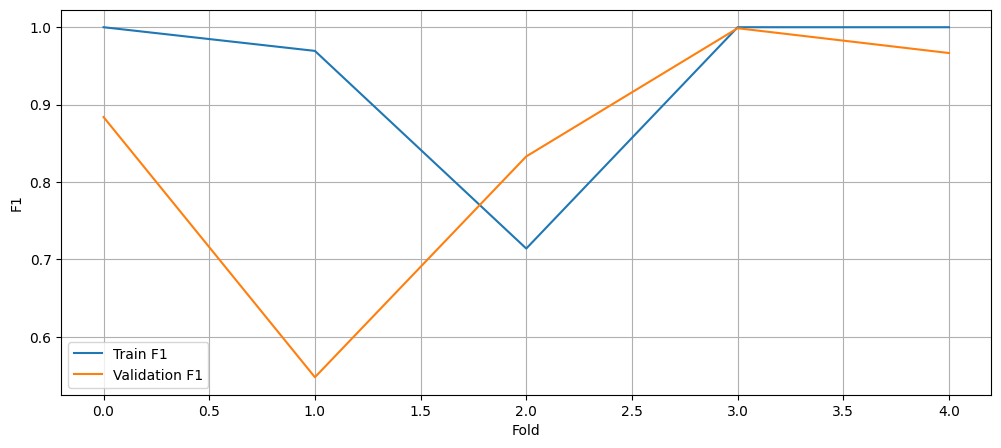

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(all_train_f1, label='Train F1')
plt.plot(all_val_f1, label='Validation F1')
plt.xlabel('Fold')
plt.ylabel('F1')
plt.legend()
plt.grid(True)
plt.show()

XGBoost

In [110]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.3, random_state=42)

In [111]:
best_params_xgb = {
    'n_estimators': 10000,
    'max_depth': 2,
    'learning_rate': 0.01,
    #'reg_lambda': 8.745111060307524,
    #'gamma': 0.2752528336534656,
    'objective': 'binary:logistic',
    'verbosity': 1,
    'tree_method': 'hist',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'feval': xgb_f1_score,
    'maximize': True
}

In [112]:
base_xgb = XGBClassifier(**best_params_xgb)

model_xgb = OneVsRestClassifier(base_xgb)

In [113]:
from sklearn import set_config

set_config(enable_metadata_routing=True)

In [116]:
all_train_f1, all_val_f1 = [], []

for train_idx, val_idx in tscv.split(X):
        train_idx = train_idx.tolist()
        val_idx = val_idx.tolist()

        X_train = X[train_idx]
        X_val = X[val_idx]
        y_train = [y_multi[i] for i in train_idx]
        y_val = [y_multi[i] for i in val_idx]

        model_xgb.fit(X_train, y_train)
        
        y_val_pred = model_xgb.predict_proba(X_val)
        y_train_pred = model_xgb.predict_proba(X_train)

        _, train_score = calculate_f1_per_target_catboost(y_train, y_train_pred)
        _, val_score = calculate_f1_per_target_catboost(y_val, y_val_pred)

        all_train_f1.append(train_score)
        all_val_f1.append(val_score)

        print('Train score:', train_score)
        print('Val score:', val_score)

Train score: 0.6331553284628891
Val score: 0.8602253826482629
Train score: 0.6999216965311713
Val score: 0.5368020398613544
Train score: 0.754448582436743
Val score: 0.7927319264413046
Train score: 0.8623304779242649
Val score: 0.9620855231705295
Train score: 0.8640724838226853
Val score: 0.9666524277374342


In [70]:
xgb_preds = model_xgb.predict_proba(X_train_xgb)

In [71]:
calculate_f1_per_target_catboost(y_train_xgb, xgb_preds)

({'R1_1': 0.9285205586965685,
  'R1_2': 1.0,
  'R2_1': 0.4998983119788489,
  'R2_2': 0.4998983119788489,
  'R3_1': 1.0,
  'R3_2': 0.8999491404740108,
  'R4_1': 1.0,
  'R4_2': 1.0,
  'R5_1': 0.4998983119788489,
  'R5_2': 0.4998983119788489,
  'R6_1': 1.0,
  'R6_2': 0.966615755354173,
  'R7_1': 1.0,
  'R7_2': 0.4998983119788489,
  'R8_1': 1.0,
  'R8_2': 1.0,
  'R9_1': 1.0,
  'R9_2': 1.0,
  'R10_1': 0.9614875605917039,
  'R10_2': 0.4998983119788489,
  'R11_1': 1.0,
  'R11_2': 0.4998983119788489,
  'R12_1': 1.0,
  'R12_2': 1.0,
  'R13_1': 0.9285205586965685,
  'R13_2': 0.944393564216501,
  'R14_1': 0.9930994711652464,
  'R14_2': 0.9705373136116653,
  'R15_1': 0.4998983119788489,
  'R15_2': 0.4998983119788489},
 0.4998983119788489)

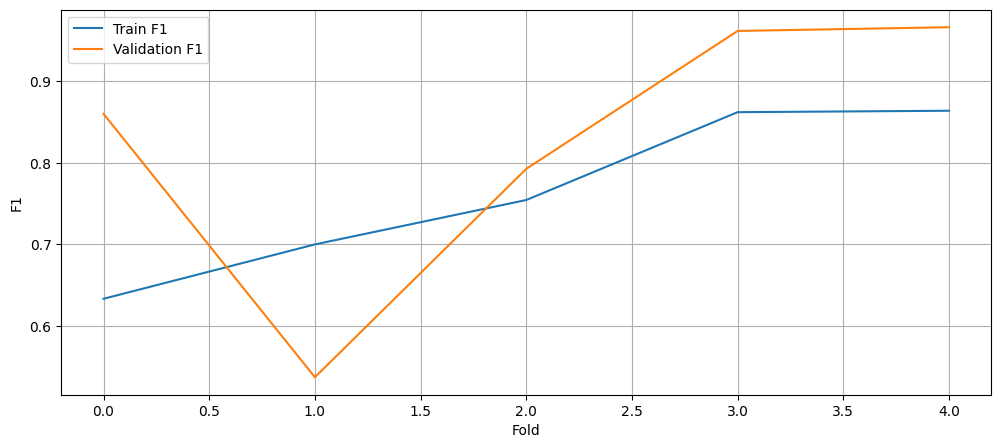

In [117]:
plt.figure(figsize=(12, 5))
plt.plot(all_train_f1, label='Train F1')
plt.plot(all_val_f1, label='Validation F1')
plt.xlabel('Fold')
plt.ylabel('F1')
plt.legend()
plt.grid(True)
plt.show()

TF LSTM

In [61]:
def create_sequences(data_X, data_y, seq_length):
    X, y = [], []

    for i in range(len(data_X) - seq_length):
        X.append(data_X[i:i + seq_length])
        y.append(data_y[i:i + seq_length])
    
    return np.array(X), np.array(y)

In [62]:
seq_length = 64

X_tf, y_tf = create_sequences(X, y, seq_length)

print(f'X shape: {X_tf.shape}\ny shape: {y_tf.shape}')

X shape: (6962, 64, 29)
y shape: (6962, 64, 30)


In [63]:
tscv = TimeSeriesSplit(n_splits=7)

In [67]:
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tf)):
    print(f'\nFold {fold + 1}')

    X_train, y_train = X_tf[train_idx], y_tf[train_idx]
    X_val, y_val = X_tf[val_idx], y_tf[val_idx]

    model_tf = Sequential()

    model_tf.add(Input((seq_length, X_tf.shape[2])))
    model_tf.add(LSTM(256, return_sequences=True, activation='tanh'))
    model_tf.add(Dropout(0.5))
    model_tf.add(LSTM(128, return_sequences=True, activation='sigmoid'))
    model_tf.add(Dropout(0.5))
    model_tf.add(Dense(30, activation='sigmoid'))

    model_tf.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=[F1Score()])

    early_stopping = EarlyStopping(
        monitor='val_f1_score',
        mode='max',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    model_tf.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=50,
              batch_size=16,
              callbacks=[early_stopping],
              verbose=1)
    
    y_pred = model_tf.predict(X_val)

    f1 = only_f1_score_lstm(y_val, y_pred)

    print(f'Fold {fold + 1} -> F1-score: {f1:.4f}')

    f1_scores.append(f1)


Fold 1
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - f1_score: 0.0045 - loss: 0.1850 - val_f1_score: 0.0000e+00 - val_loss: 0.0104
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - f1_score: 5.3609e-04 - loss: 0.0152 - val_f1_score: 0.0000e+00 - val_loss: 0.0110
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - f1_score: 0.0035 - loss: 0.0118 - val_f1_score: 8.8067e-04 - val_loss: 0.0123
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - f1_score: 0.0073 - loss: 0.0104 - val_f1_score: 0.0000e+00 - val_loss: 0.0119
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - f1_score: 0.0018 - loss: 0.0101 - val_f1_score: 0.0000e+00 - val_loss: 0.0122
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - f1_score: 0.0019 - loss: 0.0089 - val_f1_score: 0.0000e+00 - val_loss: 0.0112
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - f1_score: 0.1810 - loss: 0.0045 - val_f1_score: 0.5382 - val_loss: 0.0114
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - f1_score: 0.

In [68]:
print(f'CV F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}')

CV F1: 0.9875 ± 0.0159


In [77]:
model_tf.save('models/tf_lstm_timeseries_256-128-0.987.keras')

In [70]:
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y_tf, test_size=0.3, shuffle=False)

In [ ]:
X_tf_train.shape, X_tf_test.shape

((4873, 64, 29), (2089, 64, 29))

Only high corr targets

In [63]:
model_tf_corr = Sequential()

model_tf_corr.add(Input((seq_length, X_tf.shape[2])))
model_tf_corr.add(LSTM(256, return_sequences=True, activation='tanh'))
model_tf_corr.add(Dropout(0.5))
model_tf_corr.add(LSTM(128, return_sequences=True, activation='sigmoid'))
model_tf_corr.add(Dropout(0.5))
model_tf_corr.add(Dense(30, activation='sigmoid'))

In [64]:
model_tf_corr.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=[F1Score()])

In [65]:
history = model_tf_corr.fit(X_tf_train, y_tf_train, epochs=150, validation_data=(X_tf_test, y_tf_test))

Epoch 1/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - f1_score: 0.0024 - loss: 0.0845 - val_f1_score: 0.0000e+00 - val_loss: 0.0112
Epoch 2/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - f1_score: 0.0779 - loss: 0.0115 - val_f1_score: 0.6310 - val_loss: 0.0042
Epoch 3/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - f1_score: 0.6483 - loss: 0.0043 - val_f1_score: 0.7128 - val_loss: 0.0028
Epoch 4/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - f1_score: 0.7318 - loss: 0.0030 - val_f1_score: 0.7971 - val_loss: 0.0012
Epoch 5/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - f1_score: 0.7840 - loss: 0.0015 - val_f1_score: 0.8335 - val_loss: 9.3506e-04
Epoch 6/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - f1_score: 0.8417 - loss: 0.0011 - val_f1_score: 0.8521 - val_loss: 7.5433e-04
Epoch 7/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - f1_score: 0.8373 - loss: 9.7950e-04 - val_f1_score: 0.8803 - val_loss: 6.3447e-04
Epoch 8/150
153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - f1

In [158]:
model_tf_corr.save('models/tf_lstm_256-128-0.9999.keras')

In [71]:
preds = model_tf.predict(X_tf_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


In [72]:
calculate_f1_per_target_lstm(y_tf_test, preds)

({'R1_1': 1.0,
  'R1_2': 1.0,
  'R2_1': 1.0,
  'R2_2': 1.0,
  'R3_1': 1.0,
  'R3_2': 1.0,
  'R4_1': 1.0,
  'R4_2': 1.0,
  'R5_1': 1.0,
  'R5_2': 1.0,
  'R6_1': 0.9999924909111936,
  'R6_2': 1.0,
  'R7_1': 1.0,
  'R7_2': 1.0,
  'R8_1': 1.0,
  'R8_2': 1.0,
  'R9_1': 1.0,
  'R9_2': 1.0,
  'R10_1': 1.0,
  'R10_2': 1.0,
  'R11_1': 1.0,
  'R11_2': 1.0,
  'R12_1': 1.0,
  'R12_2': 1.0,
  'R13_1': 1.0,
  'R13_2': 1.0,
  'R14_1': 1.0,
  'R14_2': 1.0,
  'R15_1': 1.0,
  'R15_2': 1.0},
 0.9999924909111936)

In [73]:
all_preds = model_tf.predict(X_tf)

218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step


In [74]:
calculate_f1_per_target_lstm(y_tf, all_preds)

({'R1_1': 0.9999932471905256,
  'R1_2': 0.9999909944842704,
  'R2_1': 0.9996768376500229,
  'R2_2': 0.9996298984929185,
  'R3_1': 0.9996922273252795,
  'R3_2': 0.9999932511775736,
  'R4_1': 0.9997016979070202,
  'R4_2': 0.9997065018460377,
  'R5_1': 0.9999932271134594,
  'R5_2': 0.9999909514663263,
  'R6_1': 0.9996844499958687,
  'R6_2': 0.9996983832007322,
  'R7_1': 0.9999955024108146,
  'R7_2': 0.9995691099766619,
  'R8_1': 0.9996669819350372,
  'R8_2': 0.9999841439258816,
  'R9_1': 0.9996965624481307,
  'R9_2': 0.9996335952502129,
  'R10_1': 0.9996940500930531,
  'R10_2': 0.9995691099766619,
  'R11_1': 0.999993267206575,
  'R11_2': 0.9995691099766619,
  'R12_1': 0.9996785338600749,
  'R12_2': 0.9996812792141672,
  'R13_1': 0.9996785338600749,
  'R13_2': 0.9999909944842704,
  'R14_1': 0.9997094065951742,
  'R14_2': 0.9997008617998268,
  'R15_1': 0.9999932271134594,
  'R15_2': 0.9995691099766619},
 0.9995691099766619)

In [75]:
train_preds = model_tf.predict(X_tf_train)

153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step


In [76]:
calculate_f1_per_target_lstm(y_tf_train, train_preds)

({'R1_1': 0.9999903523444102,
  'R1_2': 0.9999871339338656,
  'R2_1': 0.9995383142583587,
  'R2_2': 0.9994712534060903,
  'R3_1': 0.9995603013266462,
  'R3_2': 0.999990358040663,
  'R4_1': 0.9995725163935265,
  'R4_2': 0.999580086599883,
  'R5_1': 0.999990323660528,
  'R5_2': 0.9999870724746023,
  'R6_1': 0.9995478344714792,
  'R6_2': 0.9995690961695838,
  'R7_1': 0.9999935743482753,
  'R7_2': 0.9993844049362847,
  'R8_1': 0.999524233308272,
  'R8_2': 0.9999773466440248,
  'R9_1': 0.9995664948759457,
  'R9_2': 0.999476534720039,
  'R10_1': 0.9995629057014437,
  'R10_2': 0.9993844049362847,
  'R11_1': 0.9999903809386754,
  'R11_2': 0.9993844049362847,
  'R12_1': 0.9995407380174844,
  'R12_2': 0.9995446600737692,
  'R13_1': 0.9995407380174844,
  'R13_2': 0.9999871339338656,
  'R14_1': 0.9995848453161059,
  'R14_2': 0.9995726371187631,
  'R15_1': 0.999990323660528,
  'R15_2': 0.9993844049362847},
 0.9993844049362847)

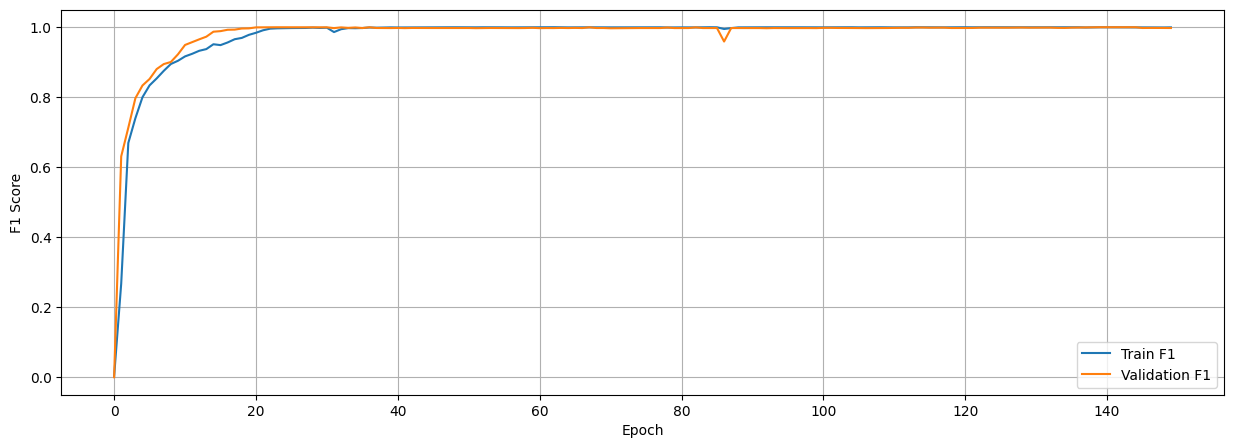

In [83]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['f1_score'], label='Train F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

_________________________________